In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import itertools

%matplotlib notebook

We are interested in the quantity $$ \mathbb{E}[\eta(t)] = \lambda \mathbb{E}[x] \mathbb{E}[\frac{1}{r}]$$ and $$\mathbb{E}[Q(t)] = \mathbb{E}[\eta(t)] \mathbb{E}[r]$$and their sensitivity to the mischaracterization of $\alpha_j$. Consider the case when we have pricing functions of the folling form: 
$$g_\ell(x_j, \alpha_j) = x_j V^\ell + \alpha_j \frac{x_j}{R^\ell}$$

Additionally, $x_j \sim f_X(x_j), \text{and } \alpha_j \sim f_A(\alpha_j)$. The $\alpha_j$ is a discrete random variable and $x_j$ is a continuous random variable. Next block sets charge rates and prices.

In [2]:
lambda_val = 20 # EVs/ hr
x_min = 10
x_max = 100
theta_min = 0
theta_max = 1

E_x = (x_max**2 - x_min**2)/(2 * (x_max - x_min)) #expected value of demand x_j (kwh)

R_ell_A = np.array([15, 30 , 35])
V_ell_A = np.array([.15, .25, .32])

R_ell_B = np.array([15, 30 , 35])
V_ell_B = np.array([.05, .25, .33])

Consider a charging facilty which offers $L$ service levels. Then, assume that the charging facility captures all of the possible population wide service level choices for users. 

Then, the total combinations of user choice subpopulations is
$$ C = \sum^L_{i = 1} \binom{L}{i}$$

where there $B_i$ subpopulations for $i \in \{1, \dots, C\}$.

In [3]:
L = len(R_ell_A)
C = 0 #Total number of combinations
levels = [i for i in range(0,L)]
comb_list = []
for i in range(1,L+1):
    combinations = list(itertools.combinations(levels, i))
    C += len(combinations)
    comb_list.append(combinations)


Next, we build a matrix that gives the ratio $$\frac{\Delta^i_k V}{\Delta^k_i \bar{R}} $$ 
where $\Delta^i_k V = V^i - V^k$, and $\Delta^k_i \bar{R} = \frac{1}{R^k} - \frac{1}{R^i}$. This ratio is important for finding probability a user will choose a specific charging rate. Specifically, the PMF of the charge rates 
$$\renewcommand{\P}{\mathbb{P}}
p_{r}(r) = 
        \begin{cases}       
            \P \left(\underline{\alpha}^1 < \alpha_j < \bar{\alpha}^1 \right) & \text{if } r = R^1 \,, \\ 
            \qquad \quad  \vdots &  \\
            \P \left(\underline{\alpha}^L < \alpha_j < \bar{\alpha}^L \right) & \text{if } r = R^L \,.
        \end{cases} 
$$
where $$\underline{\alpha}^k = \max\left\{\alpha_\text{min}, \max_{i<k}\frac{\Delta^i_k V}{\Delta^k_i \bar{R}} \right\} $$ and $$ \bar{\alpha}^k = \min\left\{\alpha_\text{max}, \min_{k < i}\frac{\Delta^i_k V}{\Delta^k_i \bar{R}} \right\}.$$ The next block prints out the ratio mentioned above in matrix format where each row is $k$ and each column is the index $i$. 

In [4]:
def compute_delta_ratio(R_ell, V_ell):
    delR = np.vstack((R_ell, R_ell))
    delV = np.vstack((V_ell, V_ell))

    for _ in range(0, R_ell.size - 2):
        delR = np.vstack((delR, R_ell))
        delV = np.vstack((delV, V_ell))

    delR = delR.astype('float')
    delR[delR==0] = np.nan

    delR = np.divide(1,delR) - np.divide(1, delR.T) 
    delV = delV.T - delV

    # print(delR, '\n', delV)
    delVdelR = np.divide(delV, delR)
    
    return delVdelR 


Given that $\alpha_j$ is a discrete random variable it has a PMF $p_A(\alpha_j)$ such that
$$p_A(\alpha_j) = \begin{cases} 
                  p_1 \quad \alpha_j = a_1 \\
                  \vdots \\
                  p_M \quad \alpha_j = a_M.
                  \end{cases} $$
In the next block we define $a$ and $p$. 
### Customize here to see effect on expected number of users

In [5]:
# PMF of alpha (arrays must be same size)
num_bins = 4
alpha_pmf_val = np.array([2, 10, 20, 25])
alpha_pmf_wt = np.ones(num_bins)/num_bins #probability weight, must sum to 1

# True PMF (can change amount of "bins")
p_hat = .3
alpha_pmf_val_true = np.array([2, 5.5, 20, 25])
alpha_pmf_wt_true = np.ones(num_bins)/num_bins#probability weight, must sum to 1

In [6]:
# PMF of The population subsets
B_pmf_wt = np.ones((C,1))/C
B_pmf_wt = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
#
B_pmf_wt_true = np.array([0.25, 0.0, 0.0, 0.25, 0.0, 0.0, 0.5])


Define a function that computes the probability of of choosing a particular rate given a set of parameters. 

In [7]:
def prob_choice(delVdelR, alpha_pmf_val, alpha_pmf_wt):
    int_bounds = [[], []]
    # Get min and max values
    alpha_min = np.min(alpha_pmf_val)
    alpha_max = np.max(alpha_pmf_val)
    prob_choosing_R = np.zeros((delVdelR.shape[0],1))
    # Loop through service levels
    for i in range(0, np.shape(delVdelR)[0]):
        if i == 0:
            lower = alpha_min
            upper = np.fmin(alpha_max, np.nanmin(delVdelR[i+1:]))
        elif i == np.shape(delVdelR)[0] - 1:
            lower = np.fmax(alpha_min, np.nanmax(delVdelR[:i]))
            upper = alpha_max
        else:
            lower = np.fmax(alpha_min,  np.nanmax(delVdelR[i][:i]))
            try:
                upper = np.fmin(alpha_max, np.nanmin(delVdelR[i][i+1:]))
            except:
                upper = alpha_max
        #         
        if upper > lower:
            int_bounds[0].append(lower)
            int_bounds[1].append(upper)
        else:
            print(f"For service level {i+1} the lower bound is greater than upper {lower},{upper}")
            
        idx = (alpha_pmf_val >= lower) & (alpha_pmf_val <= upper)
    #     print(np.where(idx)[0])
        idx = np.where(idx)
        if idx[0].size > 0:
#             print("size", idx[0].size)
            for j in range(0, idx[0].size):
                prob_choosing_R[i] += alpha_pmf_wt[idx[0][j]]
    
    return prob_choosing_R, int_bounds

Compute $\mathbb{E}[\eta(t)]$ and $\mathbb{E}^\text{true}[\eta(t)]$ and print it out.

In [8]:
def compute_E_eta(R_ell, V_ell, B_pmf_wt, alpha_pmf_val, alpha_pmf_wt, comb_list):
    int_bounds_all = []
    # Loop through different size combinations
    E_eta = 0
    count = 0
    for index_subpop_list in comb_list:
        for idx in index_subpop_list:
            R_ell_subset = R_ell[list(idx)]
            V_ell_subset = V_ell[list(idx)]
            if len(R_ell_subset) == 1:
                E_eta += lambda_val*E_x*1/R_ell_subset * B_pmf_wt[count]
            else:
                delVdelR  = compute_delta_ratio(R_ell_subset, V_ell_subset)
                prob_choosing_R, int_bounds = prob_choice(delVdelR, alpha_pmf_val, alpha_pmf_wt)
                int_bounds_all.append(int_bounds)
                E_1_r = 0

                for i in range(0, R_ell_subset.size):
                    E_1_r += prob_choosing_R[i] * (1/R_ell_subset[i]) 
                E_eta += lambda_val*E_x*E_1_r*B_pmf_wt[count]

            count += 1
    return E_eta, int_bounds_all

In [14]:
E_eta_A, int_bounds_all_A = compute_E_eta(R_ell_A, 
                                      V_ell_A, 
                                      B_pmf_wt, 
                                      alpha_pmf_val_true, 
                                      alpha_pmf_wt_true, 
                                      comb_list)

E_eta_true_A, int_bounds_all_true_A = compute_E_eta(R_ell_A, 
                                           V_ell_A, 
                                           B_pmf_wt_true, 
                                           alpha_pmf_val_true, 
                                           alpha_pmf_wt_true, 
                                           comb_list)

print(E_eta_A, E_eta_true_A, (E_eta_A-E_eta_true_A)/E_eta_true_A)
E_eta_B, int_bounds_all_B = compute_E_eta(R_ell_B, 
                                      V_ell_B, 
                                      B_pmf_wt, 
                                      alpha_pmf_val_true, 
                                      alpha_pmf_wt_true, 
                                      comb_list)

E_eta_true_B, int_bounds_all_true_B = compute_E_eta(R_ell_B, 
                                           V_ell_B, 
                                           B_pmf_wt_true, 
                                           alpha_pmf_val_true, 
                                           alpha_pmf_wt_true, 
                                           comb_list)

print(E_eta_B, E_eta_true_B, (E_eta_B-E_eta_true_B)/E_eta_true_B)


[43.21428571] [51.39880952] [-0.15923567]
[52.38095238] [58.27380952] [-0.1011236]


<ipython-input-4-b9a47e721938>:16: RuntimeWarning: invalid value encountered in true_divide
  delVdelR = np.divide(delV, delR)


In [10]:
delVdelR_A  = compute_delta_ratio(R_ell_A, V_ell_A)
print(delVdelR_A)

delVdelR_B  = compute_delta_ratio(R_ell_B, V_ell_B)
print(delVdelR_B)

[[    nan  3.      4.4625]
 [ 3.         nan 14.7   ]
 [ 4.4625 14.7        nan]]
[[  nan  6.    7.35]
 [ 6.     nan 16.8 ]
 [ 7.35 16.8    nan]]


<ipython-input-4-b9a47e721938>:16: RuntimeWarning: invalid value encountered in true_divide
  delVdelR = np.divide(delV, delR)


In [11]:
for val in int_bounds_all_A:
    print(val)
print('\n')
for val in int_bounds_all_B:
    print(val)

[[2, 3.0], [3.0, 25]]
[[2, 4.4625], [4.4625, 25]]
[[2, 14.7], [14.7, 25]]
[[2, 3.0, 14.7], [3.0, 14.7, 25]]


[[2, 6.0], [6.0, 25]]
[[2, 7.35], [7.35, 25]]
[[2, 16.8], [16.8, 25]]
[[2, 6.0, 16.8], [6.0, 16.8, 25]]


<IPython.core.display.Javascript object>


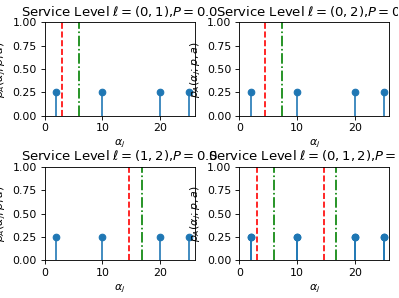

In [12]:
fig, ax = plt.subplots(2,2)
ax = np.reshape(ax, (-1,))
comb_list_sub = [tup for row in comb_list[1:] for tup in row]
B_prob_sub = B_pmf_wt[3:]
for i in range(0, len(int_bounds_all_A)):
    for vals in set(itertools.chain.from_iterable(int_bounds_all_A[i])) - set([2,25]):
        ax[i].axvline(vals, color='r',linestyle='--')
        ax[i].set_ylim([0,1])
        ax[i].stem(alpha_pmf_val, alpha_pmf_wt, basefmt=" ")
        ax[i].set_title(fr'Service Level $\ell = {comb_list_sub[i]}$,$P = {list(B_prob_sub)[i]}$'  )
        ax[i].set_xlabel(r'$\alpha_j$')
        ax[i].set_ylabel(r'$p_A(\alpha_j; p, a)$')
        ax[i].set_xlim([0,26])

for i in range(0, len(int_bounds_all_B)):
    for vals in set(itertools.chain.from_iterable(int_bounds_all_B[i])) - set([2,25]):
        ax[i].axvline(vals, color='g',linestyle='-.')
fig.tight_layout() 


<IPython.core.display.Javascript object>


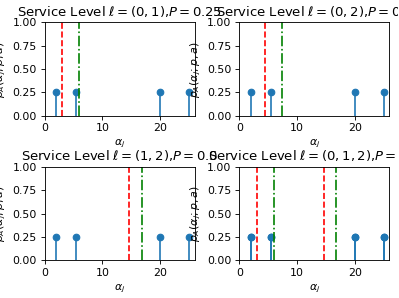

In [13]:
fig, ax = plt.subplots(2,2)
ax = np.reshape(ax, (-1,))
comb_list_sub = [tup for row in comb_list[1:] for tup in row]
B_prob_sub_true = B_pmf_wt_true[3:]
for i in range(0, len(int_bounds_all_A)):
    for vals in set(itertools.chain.from_iterable(int_bounds_all_true_A[i])) - set([2,25]):
        ax[i].axvline(vals, color='r',linestyle='--')
        ax[i].set_ylim([0,1])
        ax[i].stem(alpha_pmf_val_true, alpha_pmf_wt_true, basefmt=" ")
        ax[i].set_title(fr'Service Level $\ell = {comb_list_sub[i]}$,$P = {list(B_prob_sub_true)[i]}$'  )
        ax[i].set_xlabel(r'$\alpha_j$')
        ax[i].set_ylabel(r'$p_A(\alpha_j; p, a)$')
        ax[i].set_xlim([0,26])

for i in range(0, len(int_bounds_all_true_B)):
    for vals in set(itertools.chain.from_iterable(int_bounds_all_true_B[i])) - set([2,25]):
        ax[i].axvline(vals, color='g',linestyle='-.')
fig.tight_layout() 